In [32]:
!pip install fastf1


In [ ]:
 import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import os

In [34]:
# Create cache directory if it doesn't exist
os.makedirs("f1_cache", exist_ok=True)

# Enable FastF1 caching
fastf1.Cache.enable_cache("f1_cache")

# Dictionary to map driver codes to full names
driver_code_to_name = {
    "VER": "Max Verstappen", "NOR": "Lando Norris", "PIA": "Oscar Piastri", "RUS": "George Russell",
    "SAI": "Carlos Sainz Jr.", "ALB": "Alexander Albon", "LEC": "Charles Leclerc", "OCO": "Esteban Ocon",
    "HAM": "Lewis Hamilton", "STR": "Lance Stroll", "GAS": "Pierre Gasly", "ALO": "Fernando Alonso",
    "HUL": "Nico Hülkenberg", "TSU": "Yuki Tsunoda"
}

# Dictionary of 2025 F1 races with lat, lon, forecast times, and lap counts
race_info = {
    "Bahrain": {"lat": 26.0325, "lon": 50.5106, "forecast_time": "2025-04-30 15:00:00", "laps": 57},
    "Saudi Arabia": {"lat": 21.4225, "lon": 39.1818, "forecast_time": "2025-04-20 18:00:00", "laps": 50},
    "Japan": {"lat": 34.8823, "lon": 136.5845, "forecast_time": "2025-04-05 14:00:00", "laps": 53},
    "China": {"lat": 31.3389, "lon": 121.2200, "forecast_time": "2025-04-13 14:00:00", "laps": 56},
    "Miami": {"lat": 25.7617, "lon": -80.1918, "forecast_time": "2025-05-04 13:00:00", "laps": 57},
    "Emilia Romagna": {"lat": 44.3439, "lon": 11.7167, "forecast_time": "2025-05-18 06:00:00", "laps": 63},
    "Monaco": {"lat": 43.7384, "lon": 7.4246, "forecast_time": "2025-05-25 13:00:00", "laps": 78}
}

In [35]:


# Function to load and preprocess data
def load_f1_data(year, race_name, session_type="R"):
    session = fastf1.get_session(year, race_name, session_type)
    session.load()
    laps = session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
    laps.dropna(inplace=True)
    
    # Convert times to seconds
    for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
        laps[f"{col} (s)"] = laps[col].dt.total_seconds()
    
    # Aggregate sector times by driver
    sector_times = laps.groupby("Driver").agg({
        "Sector1Time (s)": "mean",
        "Sector2Time (s)": "mean",
        "Sector3Time (s)": "mean"
    }).reset_index()
    sector_times["TotalSectorTime (s)"] = (
        sector_times["Sector1Time (s)"] + 
        sector_times["Sector2Time (s)"] + 
        sector_times["Sector3Time (s)"]
    )
    return laps, sector_times


In [36]:
# Function to fetch weather data
def get_weather_data(lat, lon, forecast_time, api_key):
    weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}&units=metric"
    try:
        response = requests.get(weather_url)
        response.raise_for_status()
        weather_data = response.json()
        forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)
        rain_probability = forecast_data["pop"] if forecast_data else 0
        temperature = forecast_data["main"]["temp"] if forecast_data else 20
    except (requests.RequestException, KeyError):
        print("Warning: Failed to fetch weather data. Using default values.")
        rain_probability, temperature = 0, 20
    return rain_probability, temperature


Available races: Bahrain, Saudi Arabia, Japan, China, Miami, Emilia Romagna, Monaco


Enter the 2025 race name (e.g., Miami, Monaco, Bahrain):  Japan


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No c


🏁 Predicted 2025 Japan GP Winner 🏁

              Driver  PredictedAvgLapTime (s)  EstimatedTotalRaceTime (s)
0     Max Verstappen                96.975560                 5183.704681
1   Carlos Sainz Jr.                97.345580                 5203.315740
2    Charles Leclerc                97.417480                 5207.126440
3       Lando Norris                97.531600                 5213.174800
4     Lewis Hamilton                97.670391                 5220.530716
5     George Russell                97.766740                 5225.637220
6      Oscar Piastri                97.849040                 5229.999120
7    Fernando Alonso                98.521143                 5265.620562
8    Nico Hülkenberg                98.903449                 5285.882796
9       Lance Stroll                99.019673                 5292.042693
10      Pierre Gasly                99.174275                 5300.236574
11      Esteban Ocon               100.458840                 5368.318518



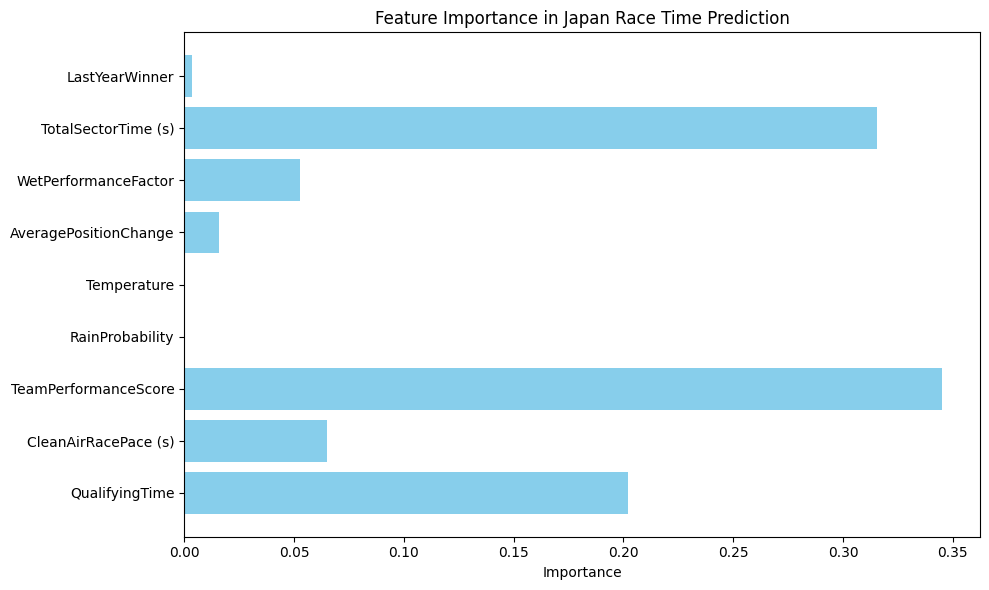

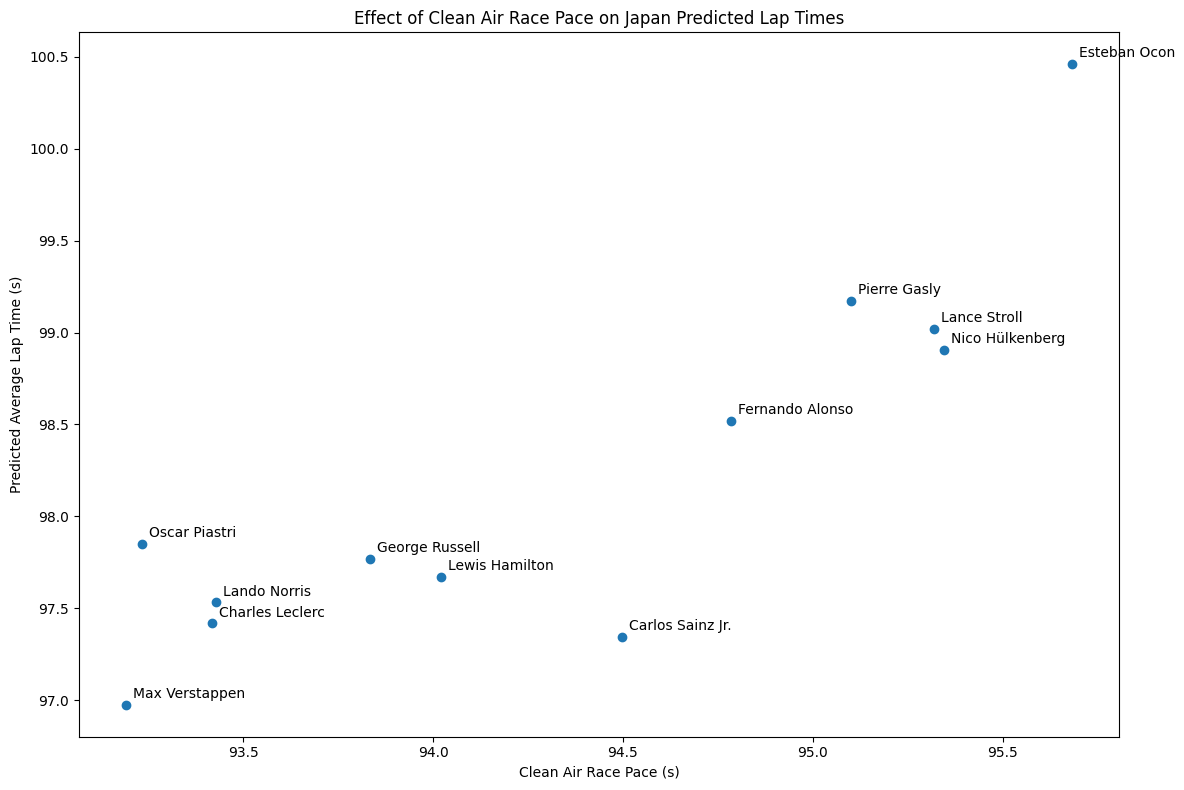

In [39]:


# Main prediction function
def predict_f1_winner(race_name, year=2025, qualifying_data=None, lat=None, lon=None, forecast_time=None, api_key="YOURAPIKEY", num_laps=57):
    # Load 2024 race data
    try:
        laps_2024, sector_times_2024 = load_f1_data(2024, race_name)
    except ValueError as e:
        print(f"Error: Invalid race name '{race_name}'. Please check FastF1 supported races.")
        return None, None
    
    # Clean air race pace (example values, replace with real data)
    clean_air_race_pace = {
        "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
        "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
        "OCO": 95.682128, "TSU": 95.0, "GAS": 95.1, "ALB": 95.2
    }

 # Wet performance factors
    wet_performance = {
        "VER": 0.975196, "HAM": 0.976464, "LEC": 0.975862, "NOR": 0.978179, "ALO": 0.972655,
        "RUS": 0.968678, "SAI": 0.978754, "TSU": 0.996338, "OCO": 0.981810, "GAS": 0.978832,
        "STR": 0.979857, "PIA": 0.98, "ALB": 0.98, "HUL": 0.98
    }
    

    # Team points (example values, update with real 2025 data)
    team_points = {
        "McLaren": 279, "Mercedes": 147, "Red Bull": 131, "Williams": 51, "Ferrari": 114,
        "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
    }
    max_points = max(team_points.values())
    team_performance_score = {team: points / max_points for team, points in team_points.items()}
    
    driver_to_team = {
        "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
        "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
        "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin", "ALB": "Williams"
    }
    
    # Average position change (example for Monaco-like tracks, adjust per race)
    average_position_change = {
        "VER": -1.0, "NOR": 1.0, "PIA": 0.2, "RUS": 0.5, "SAI": -0.3, "ALB": 0.8,
        "LEC": -1.5, "OCO": -0.2, "HAM": 0.3, "STR": 1.1, "GAS": -0.4, "ALO": -0.6, "HUL": 0.0, "TSU": 0.0
    }
    
    # Process qualifying data
    qualifying_2025 = pd.DataFrame(qualifying_data)
    qualifying_2025["WetPerformanceFactor"] = qualifying_2025["Driver"].map(wet_performance)
    qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)
    qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
    qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)
    qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change)
    
    # Fetch weather data
    rain_probability, temperature = get_weather_data(lat, lon, forecast_time, api_key)
    
    # Adjust qualifying times for wet conditions
    if rain_probability >= 0.75:
        qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
    else:
        qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]
    
    # Merge with sector times
    merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], left_on="Driver", right_on="Driver", how="left")
    merged_data["RainProbability"] = rain_probability
    merged_data["Temperature"] = temperature
    merged_data["LastYearWinner"] = (merged_data["Driver"] == "VER").astype(int)  # Update based on actual 2024 winner
    
    # Filter valid drivers
    valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
    merged_data = merged_data[valid_drivers]
    
    # Map driver codes to full names
    merged_data["DriverName"] = merged_data["Driver"].map(driver_code_to_name)
    
    # Define features and target
    X = merged_data[[
        "QualifyingTime", "CleanAirRacePace (s)", "TeamPerformanceScore", 
        "RainProbability", "Temperature", "AveragePositionChange", 
        "WetPerformanceFactor", "TotalSectorTime (s)", "LastYearWinner"
    ]]
    y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])
    
    # Impute missing values
    imputer = SimpleImputer(strategy="median")
    X_imputed = imputer.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=38)
    
    # Train model
    model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=38)
    model.fit(X_train, y_train)
    
    # Predict race times
    merged_data["PredictedAvgLapTime (s)"] = model.predict(X_imputed)
    
    # Estimate total race time (assuming 2 pit stops of 22 seconds each)
    pit_stop_time = 44  # 2 pit stops * 22 seconds
    merged_data["EstimatedTotalRaceTime (s)"] = (merged_data["PredictedAvgLapTime (s)"] * num_laps) + pit_stop_time
    
    # Sort results
    final_results = merged_data.sort_values("PredictedAvgLapTime (s)").reset_index(drop=True)
    
    # Print predictions with full driver names
    print(f"\n🏁 Predicted {year} {race_name} GP Winner 🏁\n")
    print(final_results[["DriverName", "PredictedAvgLapTime (s)", "EstimatedTotalRaceTime (s)"]].rename(columns={"DriverName": "Driver"}))
    
    # Evaluate model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\n🔍 Model Error (MAE): {mae:.2f} seconds")
    
    # Podium prediction
    podium = final_results.loc[:2, ["DriverName", "PredictedAvgLapTime (s)", "EstimatedTotalRaceTime (s)"]]
    print("\n🏆 Predicted Podium 🏆")
    print(f"🥇 P1: {podium.iloc[0]['DriverName']} (Avg Lap: {podium.iloc[0]['PredictedAvgLapTime (s)']:.2f}s, Total: {podium.iloc[0]['EstimatedTotalRaceTime (s)']/60:.2f} min)")
    print(f"🥈 P2: {podium.iloc[1]['DriverName']} (Avg Lap: {podium.iloc[1]['PredictedAvgLapTime (s)']:.2f}s, Total: {podium.iloc[1]['EstimatedTotalRaceTime (s)']/60:.2f} min)")
    print(f"🥉 P3: {podium.iloc[2]['DriverName']} (Avg Lap: {podium.iloc[2]['PredictedAvgLapTime (s)']:.2f}s, Total: {podium.iloc[2]['EstimatedTotalRaceTime (s)']/60:.2f} min)")
    
    # Plot feature importance
    feature_importance = model.feature_importances_
    features = X.columns
    plt.figure(figsize=(10, 6))
    plt.barh(features, feature_importance, color='skyblue')
    plt.xlabel("Importance")
    plt.title(f"Feature Importance in {race_name} Race Time Prediction")
    plt.tight_layout()
    plt.show()
    
    # Plot clean air race pace vs predicted lap time
    plt.figure(figsize=(12, 8))
    plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedAvgLapTime (s)"])
    for i, driver in enumerate(final_results["DriverName"]):
        plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedAvgLapTime (s)"].iloc[i]),
                     xytext=(5, 5), textcoords='offset points')
    plt.xlabel("Clean Air Race Pace (s)")
    plt.ylabel("Predicted Average Lap Time (s)")
    plt.title(f"Effect of Clean Air Race Pace on {race_name} Predicted Lap Times")
    plt.tight_layout()
    plt.show()
    
    return final_results, mae
# Example usage with user input
if __name__ == "__main__":
    # Prompt user for race name
    print("Available races:", ", ".join(race_info.keys()))
    race_name = input("Enter the 2025 race name (e.g., Miami, Monaco, Bahrain): ").strip()
    
    if race_name not in race_info:
        print(f"Error: '{race_name}' is not in the list of available races. Please choose from:", ", ".join(race_info.keys()))
    else:
        # Example qualifying data (replace with actual data)
        qualifying_data = {
            "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO", "HAM", "STR", "GAS", "ALO", "HUL"],
            "QualifyingTime (s)": [90.423, 90.267, 89.841, 90.009, 90.680, 92.067, 90.175, 91.886, 90.772, 92.283, 90.216, 91.886, 91.303]
        }

       
 # Get race-specific info
        lat = race_info[race_name]["lat"]
        lon = race_info[race_name]["lon"]
        forecast_time = race_info[race_name]["forecast_time"]
        num_laps = race_info[race_name]["laps"]
        api_key = "your_actual_api_key_here"  # Replace with your OpenWeatherMap API key
        
        final_results, mae = predict_f1_winner(race_name, qualifying_data=qualifying_data, lat=lat, lon=lon, 
                                               forecast_time=forecast_time, api_key=api_key, num_laps=num_laps)